Import of all the necessary libraries for the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

Dataset loading to be used accross project

In [2]:
try:
    train_df = pd.read_csv('/content/train.csv')
    print("Training data loaded successfully!")
except FileNotFoundError:
    print("Error: train.csv not found. Make sure the file is in the correct directory.")
    train_df = None


Training data loaded successfully!


Initial exploration (if data is correctly loaded)


--- First few rows of the training data ---
   id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0             0.5   
1   1   70         165          65       89.0             0.6   
2   2   20         170          75       81.0             0.4   
3   3   35         180          95      105.0             1.5   
4   4   30         165          60       80.5             1.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  LDL  \
0              0.6              1               1       135  ...   40   75   
1              0.7              2               2       146  ...   57  126   
2              0.5              1               1       118  ...   45   93   
3              1.2              1               1       131  ...   38  102   
4              1.0              1               1       121  ...   44   93   

   hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
0        16.5  

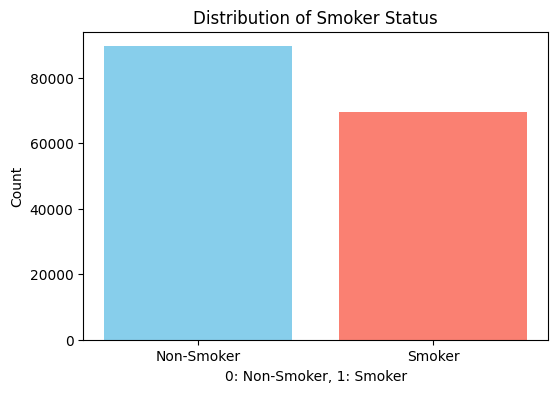

In [3]:
if train_df is not None:
    print("\n--- First few rows of the training data ---")
    print(train_df.head())

    print("\n--- Information about the dataset ---")
    train_df.info()

    print("\n--- Summary statistics of numerical features ---")
    print(train_df.describe())

    print("\n--- Distribution of the target variable ('smoking') ---")
    print(train_df['smoking'].value_counts())
    smoking_counts = train_df['smoking'].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(smoking_counts.index, smoking_counts.values, color=['skyblue', 'salmon'])
    plt.title('Distribution of Smoker Status')
    plt.xlabel('0: Non-Smoker, 1: Smoker')
    plt.ylabel('Count')
    plt.xticks(smoking_counts.index, ['Non-Smoker', 'Smoker']) # Ensure proper labels
    plt.show()


Initial exploration of a few bio-signal features


--- Histograms of a few numerical features ---


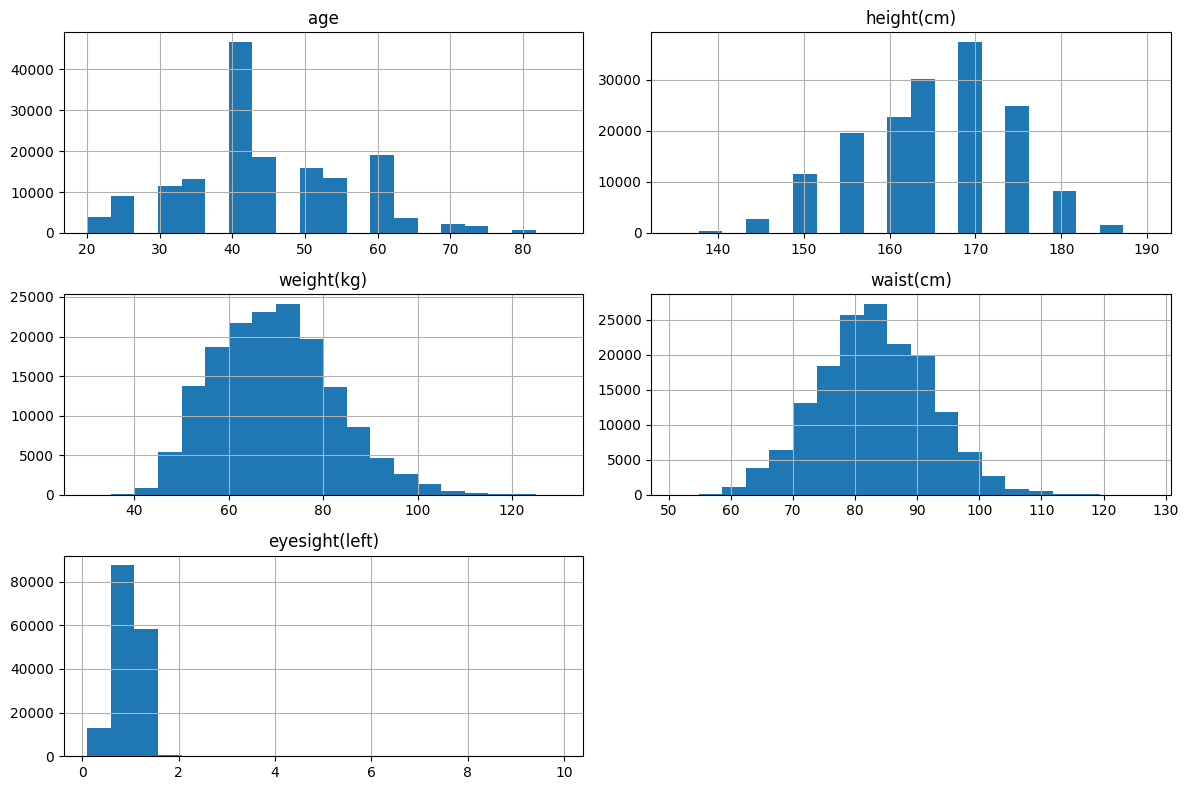


--- Box plots of a few numerical features vs. 'smoking' ---


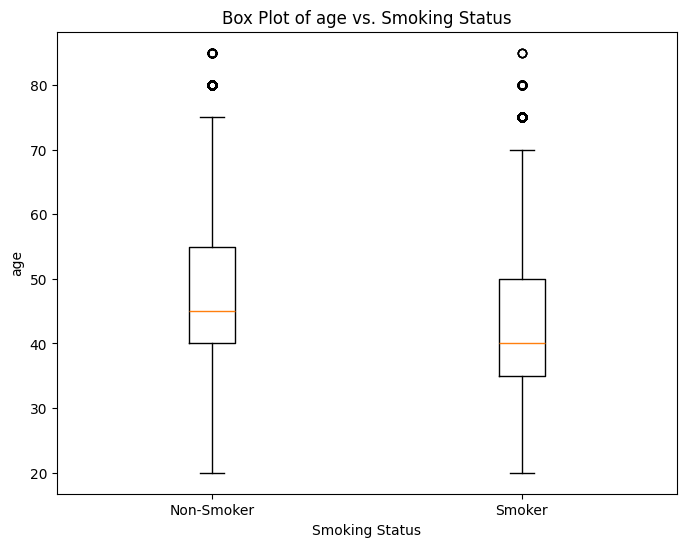

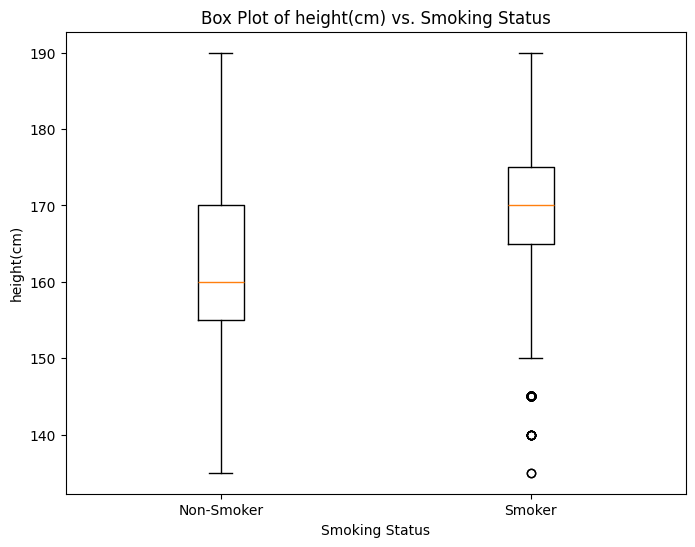

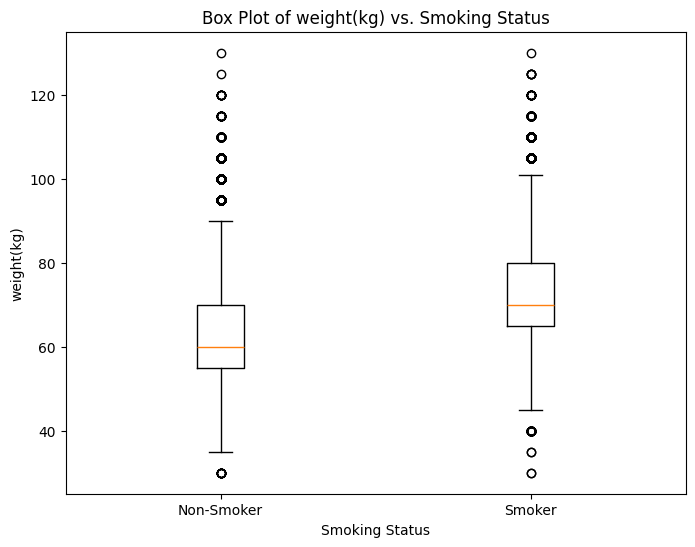

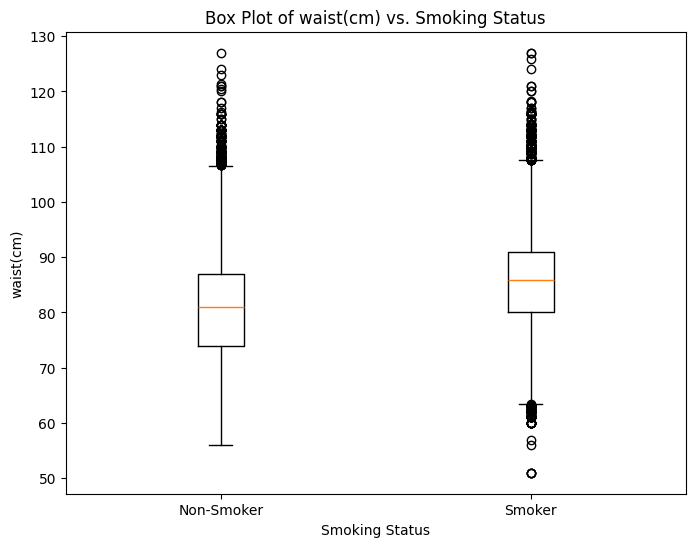

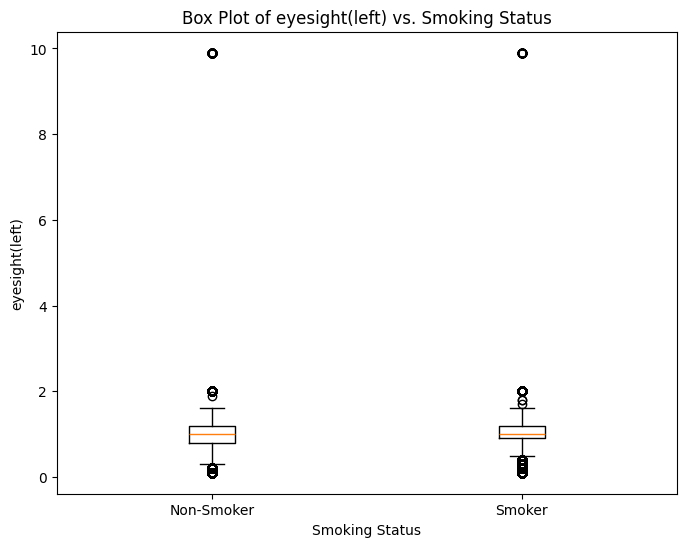

In [4]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('id')
if 'smoking' in numerical_cols:
    numerical_cols.remove('smoking')

if numerical_cols:
    print("\n--- Histograms of a few numerical features ---")
    num_to_plot = min(5, len(numerical_cols))
    train_df[numerical_cols[:num_to_plot]].hist(figsize=(12, 8), bins=20)
    plt.tight_layout()
    plt.show()

    print("\n--- Box plots of a few numerical features vs. 'smoking' ---")
    for col in numerical_cols[:num_to_plot]:
        plt.figure(figsize=(8, 6))
        smoker_data = train_df[train_df['smoking'] == 1][col]
        non_smoker_data = train_df[train_df['smoking'] == 0][col]
        plt.boxplot([non_smoker_data, smoker_data], tick_labels=['Non-Smoker', 'Smoker'])
        plt.title(f'Box Plot of {col} vs. Smoking Status')
        plt.ylabel(col)
        plt.xlabel('Smoking Status')
        plt.show()


Data Preprocessing

Number of Non-Smokers: 89603
Number of Smokers: 69653


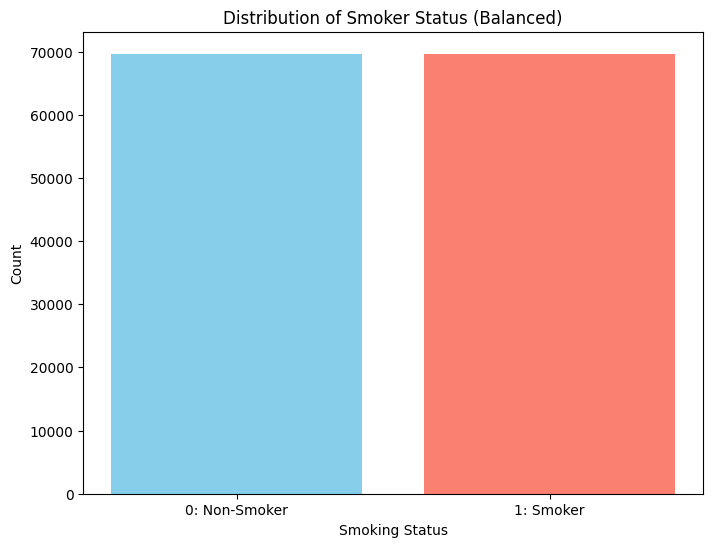


Class distribution in the balanced DataFrame:
smoking
1    69653
0    69653
Name: count, dtype: int64


In [5]:
if train_df is not None:
  # Count the number of samples in each class
  smoker_count = train_df['smoking'].value_counts()[1]
  non_smoker_count = train_df['smoking'].value_counts()[0]
  print(f"Number of Non-Smokers: {non_smoker_count}")
  print(f"Number of Smokers: {smoker_count}")

  # Identify the indices of each class
  smoker_indices = train_df[train_df['smoking'] == 1].index
  non_smoker_indices = train_df[train_df['smoking'] == 0].index

  # Randomly select the same number of non-smoker indices as smoker indices
  random_non_smoker_indices = np.random.choice(non_smoker_indices, smoker_count, replace=False)

  # Combine the smoker indices with the randomly selected non-smoker indices
  balanced_indices = np.concatenate([smoker_indices, random_non_smoker_indices])

  # Create a new balanced DataFrame
  balanced_df = train_df.loc[balanced_indices]

  # Check the class distribution in the balanced DataFrame
  smoking_counts = balanced_df['smoking'].value_counts()
  labels = ['Non-Smoker', 'Smoker']
  counts = [smoking_counts[0], smoking_counts[1]]
  colors = ['skyblue', 'salmon']

  plt.figure(figsize=(8, 6))
  plt.bar(labels, counts, color=colors)
  plt.title('Distribution of Smoker Status (Balanced)')
  plt.xlabel('Smoking Status')
  plt.ylabel('Count')
  plt.xticks(labels, ['0: Non-Smoker', '1: Smoker'])
  plt.show()

  print("\nClass distribution in the balanced DataFrame:")
  print(balanced_df['smoking'].value_counts())


In [6]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def winsorize_outliers_iqr(data, column):
    lower_bound, upper_bound = detect_outliers_iqr(data, column)
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    return data

if balanced_df is not None:
    # Separate features (X) and target (y) from balanced_df
    X = balanced_df.drop('smoking', axis=1).drop('id', axis=1).copy() # Use .copy() to avoid SettingWithCopyWarning
    y = balanced_df['smoking'].copy()

    # Identify numerical features
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    print("\nNumerical features:", numerical_cols)

    # Handle missing values (Imputation with Median)
    imputer = SimpleImputer(strategy='median')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])
    print("\nMissing values imputed using the median.")
    print("Number of missing values after imputation:")
    print(X.isnull().sum())

    # Split data into training and validation sets BEFORE outlier handling
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("\nData split into training and validation sets (before outlier handling):")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # Outlier Handling on TRAINING data
    print("\n--- Applying IQR-based outlier winsorizing to TRAINING data ---")
    X_train_winsorized = X_train.copy()
    for col in numerical_cols:
        X_train_winsorized = winsorize_outliers_iqr(X_train_winsorized, col)
    print("Outlier winsorizing (IQR) applied to training data.")

    # Apply the SAME winsorizing bounds to VALIDATION data
    print("\n--- Applying the SAME IQR bounds to VALIDATION data ---")
    X_val_winsorized = X_val.copy()
    for col in numerical_cols:
        lower_bound, upper_bound = detect_outliers_iqr(X_train, col)
        X_val_winsorized[col] = np.where(X_val_winsorized[col] < lower_bound, lower_bound, X_val_winsorized[col])
        X_val_winsorized[col] = np.where(X_val_winsorized[col] > upper_bound, upper_bound, X_val_winsorized[col])
    print("Outlier winsorizing (IQR) applied to validation data using training bounds.")

    # Feature Scaling (StandardScaler) AFTER outlier handling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_winsorized[numerical_cols])
    X_val_scaled = scaler.transform(X_val_winsorized[numerical_cols]) # Use transform on validation data

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_winsorized.index)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=numerical_cols, index=X_val_winsorized.index)

    # Drop original numerical columns and concatenate scaled ones
    X_train_processed = X_train_winsorized.drop(numerical_cols, axis=1)
    X_train_processed = pd.concat([X_train_processed, X_train_scaled_df], axis=1)

    X_val_processed = X_val_winsorized.drop(numerical_cols, axis=1)
    X_val_processed = pd.concat([X_val_processed, X_val_scaled_df], axis=1)

    print("\nNumerical features scaled using StandardScaler (after outlier handling).")
    print("\nFirst few rows of processed training features:")
    print(X_train_processed.head())
    print("\nFirst few rows of processed validation features:")
    print(X_val_processed.head())

    print("\nProcessed data shapes:")
    print(f"X_train_processed shape: {X_train_processed.shape}, y_train shape: {y_train.shape}")
    print(f"X_val_processed shape: {X_val_processed.shape}, y_val shape: {y_val.shape}")



Numerical features: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']

Missing values imputed using the median.
Number of missing values after imputation:
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

Data split into training a

Optional Exploration of the Preprocessed Data


--- Histograms of a few numerical features (Original Data) ---




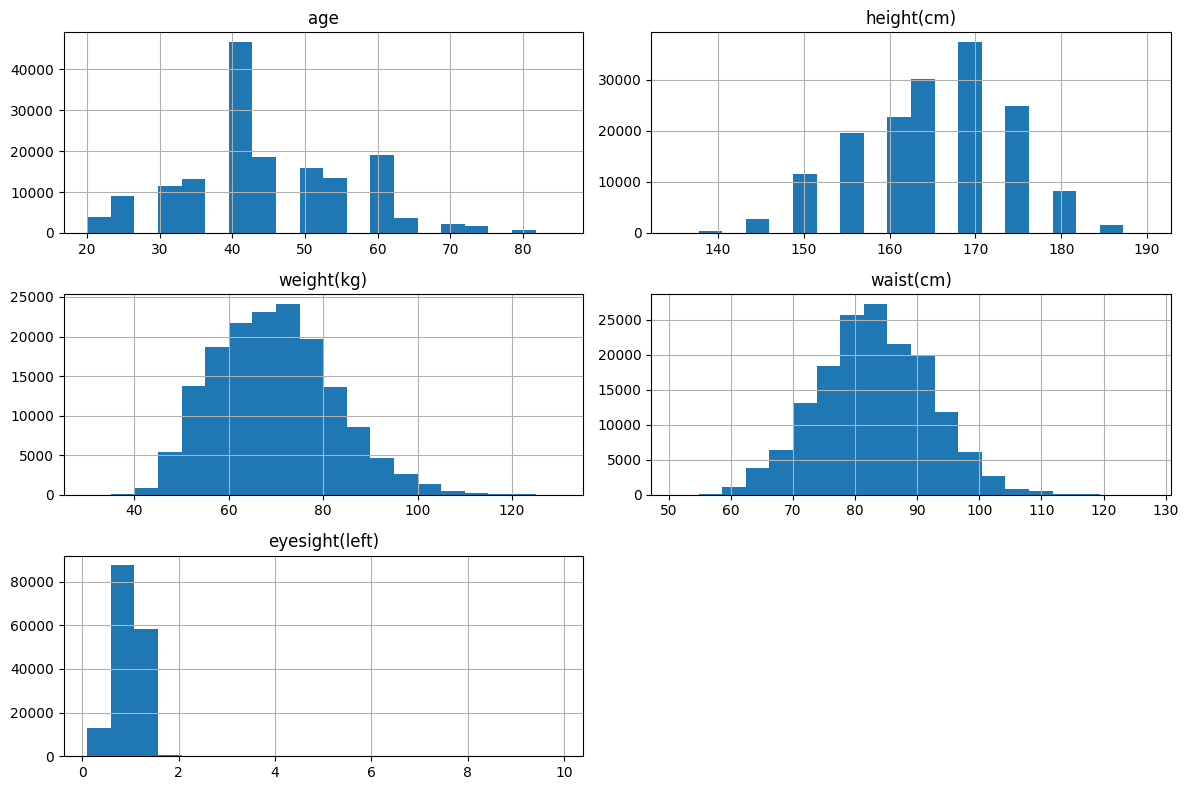




--- Box plots of a few numerical features vs. 'smoking' (Original Data) ---




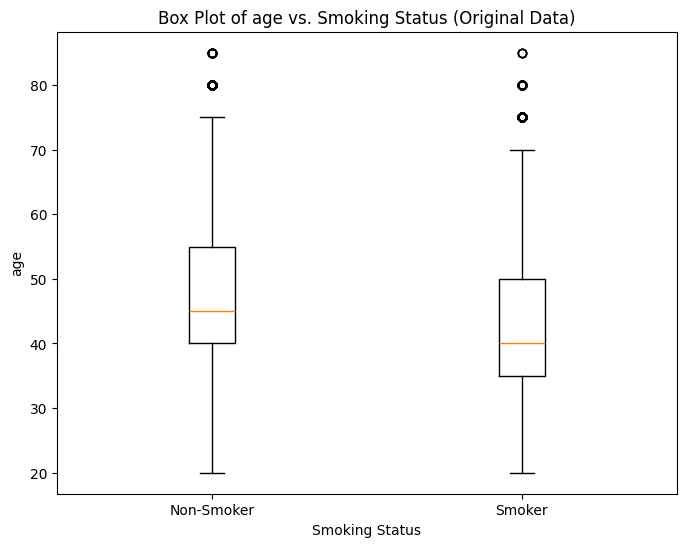

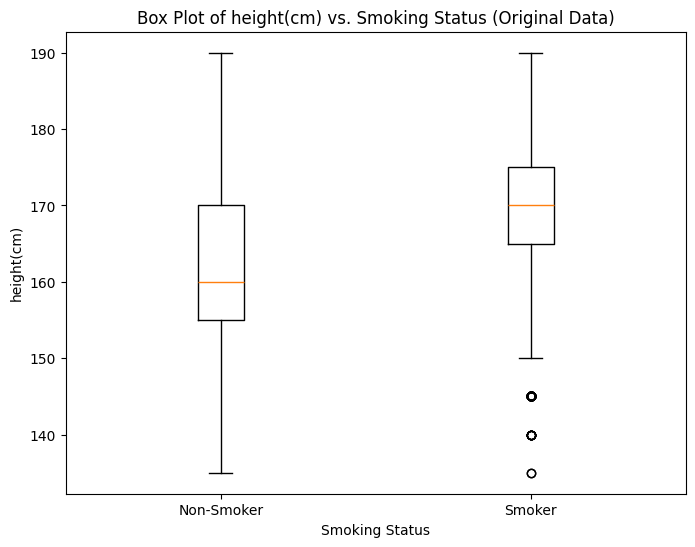

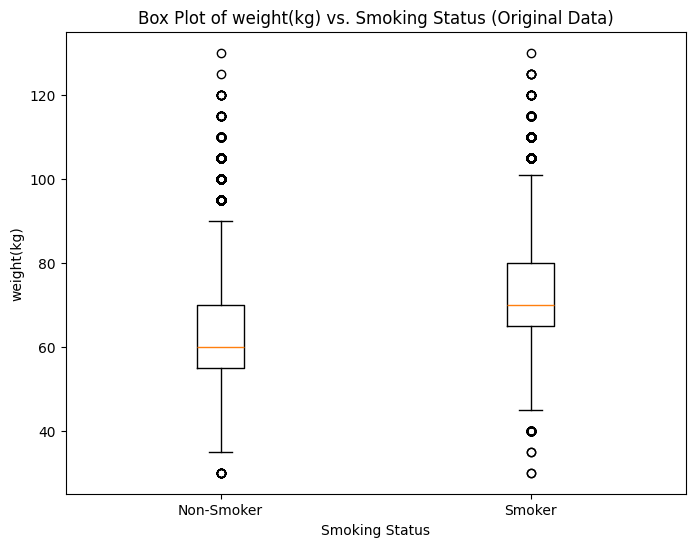

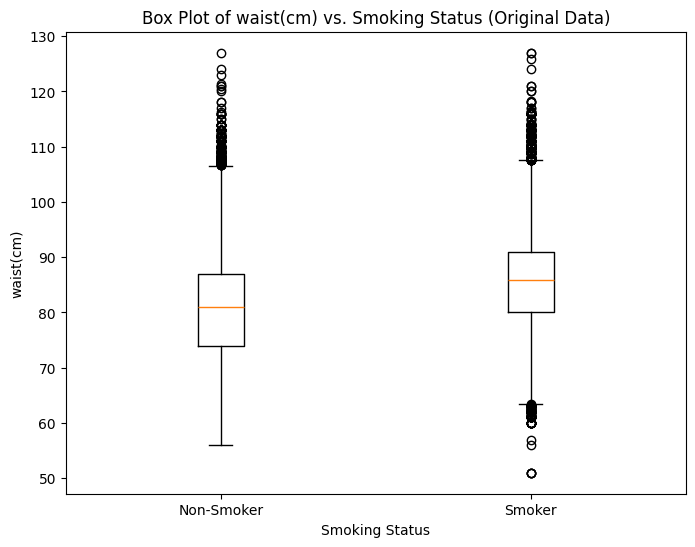

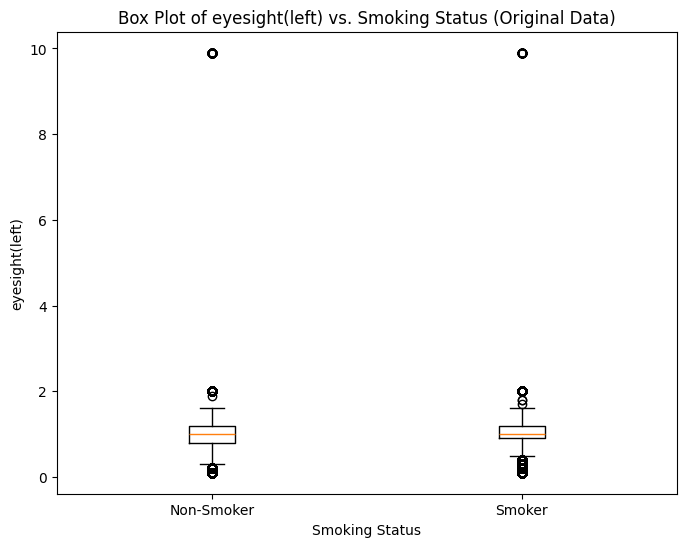

In [7]:
numerical_cols_original = train_df.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_cols_original:
    numerical_cols_original.remove('id')
if 'smoking' in numerical_cols_original:
    numerical_cols_original.remove('smoking')

if numerical_cols_original:
    print("\n--- Histograms of a few numerical features (Original Data) ---")
    print("\n")
    num_to_plot = min(5, len(numerical_cols_original))
    train_df[numerical_cols_original[:num_to_plot]].hist(figsize=(12, 8), bins=20)
    plt.tight_layout()
    plt.show()

    print("\n")
    print("\n--- Box plots of a few numerical features vs. 'smoking' (Original Data) ---")
    for col in numerical_cols_original[:num_to_plot]:
        print("\n")
        plt.figure(figsize=(8, 6))
        smoker_data_orig = train_df[train_df['smoking'] == 1][col]
        non_smoker_data_orig = train_df[train_df['smoking'] == 0][col]
        plt.boxplot([non_smoker_data_orig, smoker_data_orig], tick_labels=['Non-Smoker', 'Smoker'])
        plt.title(f'Box Plot of {col} vs. Smoking Status (Original Data)')
        plt.ylabel(col)
        plt.xlabel('Smoking Status')
        plt.show()


Decision Tree Implementation

Decision Tree model trained!

--- Decision Tree Validation Metrics ---
Accuracy: 0.7605
Precision: 0.7130
Recall: 0.8722
F1-Score: 0.7846


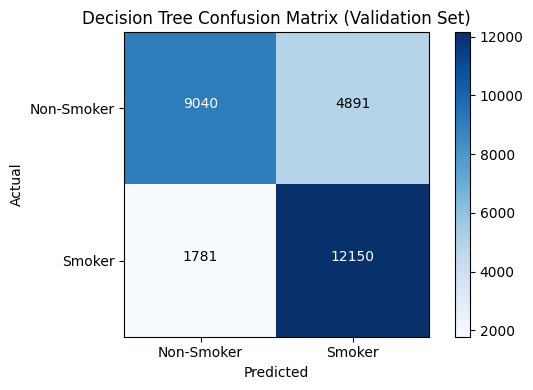

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize Decision Tree model - Best Combination
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
)

# Train the model
dt_classifier.fit(X_train_processed, y_train)

print("Decision Tree model trained!")

# 1. Make predictions on the validation set
y_pred_dt = dt_classifier.predict(X_val_processed)

# 2. Evaluate the model
accuracy_dt = accuracy_score(y_val, y_pred_dt)
precision_dt = precision_score(y_val, y_pred_dt)
recall_dt = recall_score(y_val, y_pred_dt)
f1_dt = f1_score(y_val, y_pred_dt)
cm_dt = confusion_matrix(y_val, y_pred_dt)

print("\n--- Decision Tree Validation Metrics ---")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")

# 3. Display the confusion matrix using Matplotlib
plt.figure(figsize=(6, 4))
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix (Validation Set)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Smoker', 'Smoker'])
plt.yticks(tick_marks, ['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add annotations to the confusion matrix
rows, cols = cm_dt.shape
thresh = cm_dt.max() / 2.
for i in range(rows):
    for j in range(cols):
        plt.text(j, i, f'{cm_dt[i, j]}', horizontalalignment="center", color="white" if cm_dt[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid to search
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the scoring metric (you can use accuracy or F1-score)
scorer = make_scorer(f1_score)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,  # Number of cross-validation folds
                           n_jobs=-1) # Use all available cores

# Fit GridSearchCV to the training data
grid_search.fit(X_train_processed, y_train)

# Get the best parameters and the best score
best_params_dt = grid_search.best_params_
best_score_dt = grid_search.best_score_

print("\n--- Best Hyperparameters for Decision Tree ---")
print(f"Best Parameters: {best_params_dt}")
print(f"Best F1-Score (Cross-Validation): {best_score_dt:.4f}")

# Use the best model for evaluation on the validation set
best_dt_classifier = grid_search.best_estimator_

# Evaluate on the validation set (as you did before)
y_pred_best_dt = best_dt_classifier.predict(X_val_processed)
accuracy_best_dt = accuracy_score(y_val, y_pred_best_dt)
precision_best_dt = precision_score(y_val, y_pred_best_dt)
recall_best_dt = recall_score(y_val, y_pred_best_dt)
f1_best_dt = f1_score(y_val, y_pred_best_dt)
cm_best_dt = confusion_matrix(y_val, y_pred_best_dt)

print("\n--- Performance of Best Decision Tree on Validation Set ---")
print(f"Accuracy: {accuracy_best_dt:.4f}")
print(f"Precision: {precision_best_dt:.4f}")
print(f"Recall: {recall_best_dt:.4f}")
print(f"F1-Score: {f1_best_dt:.4f}")

# You can also display the confusion matrix for the best model
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.title('Best Decision Tree Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Best Hyperparameters for Decision Tree ---
Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best F1-Score (Cross-Validation): 0.7873


NameError: name 'accuracy_score' is not defined

k-Nearest Neighbors Implementation

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize k-NN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_classifier.fit(X_train_processed, y_train)

print("k-Nearest Neighbors model trained!")

k-Nearest Neighbors model trained!


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Initialize k-NN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid to search for k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Define the scoring metric
scorer_knn = make_scorer(f1_score)

# Perform GridSearchCV for k-NN
grid_search_knn = GridSearchCV(estimator=knn_classifier,
                              param_grid=param_grid_knn,
                              scoring=scorer_knn,
                              cv=5,
                              n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_knn.fit(X_train_processed, y_train)

# Get the best parameters and the best score for k-NN
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("\n--- Best Hyperparameters for k-Nearest Neighbors ---")
print(f"Best Parameters: {best_params_knn}")
print(f"Best F1-Score (Cross-Validation): {best_score_knn:.4f}")

# Use the best k-NN model for evaluation on the validation set
best_knn_classifier = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn_classifier.predict(X_val_processed)

# Evaluate the best k-NN model
accuracy_best_knn = accuracy_score(y_val, y_pred_best_knn)
precision_best_knn = precision_score(y_val, y_pred_best_knn)
recall_best_knn = recall_score(y_val, y_pred_best_knn)
f1_best_knn = f1_score(y_val, y_pred_best_knn)
cm_best_knn = confusion_matrix(y_val, y_pred_best_knn)

print("\n--- Performance of Best k-Nearest Neighbors on Validation Set ---")
print(f"Accuracy: {accuracy_best_knn:.4f}")
print(f"Precision: {precision_best_knn:.4f}")
print(f"Recall: {recall_best_knn:.4f}")
print(f"F1-Score: {f1_best_knn:.4f}")

# Display the confusion matrix for the best k-NN model
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_knn, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.title('Best k-Nearest Neighbors Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Support Vector Machine Implementation

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_classifier = SVC(
    kernel='rbf', # rbf / poly / sigmoid (non-linear)
    random_state=42
  )

# Train the SVM model
svm_classifier.fit(X_train_processed, y_train)

print("Support Vector Machine model trained!")

Neural Network Implementation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7619 - loss: 0.4798 - val_accuracy: 0.7788 - val_loss: 0.4635
Epoch 2/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7807 - loss: 0.4590 - val_accuracy: 0.7796 - val_loss: 0.4584
Epoch 3/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7790 - loss: 0.4599 - val_accuracy: 0.7808 - val_loss: 0.4573
Epoch 4/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7836 - loss: 0.4516 - val_accuracy: 0.7817 - val_loss: 0.4570
Epoch 5/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7821 - loss: 0.4529 - val_accuracy: 0.7795 - val_loss: 0.4581
Epoch 6/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7815 - loss: 0.4504 - val_accuracy: 0.7817 - val_loss: 0.4558
Epoch 7/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7817 - loss: 0.4534 - val_accuracy: 0.7801 - val_loss: 0.4581
Epoch 8/10
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7819 - loss: 0.45

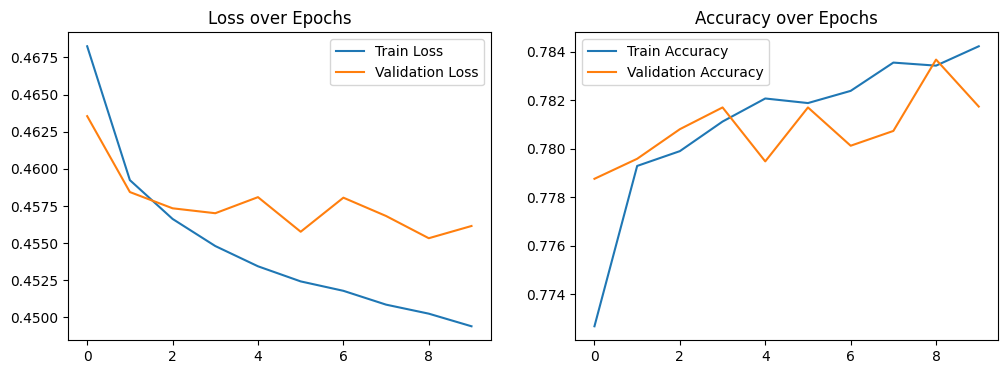

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the Neural Network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32

history = model.fit(X_train_processed, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_processed, y_val))

print("Neural Network model trained!")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()